In [1]:
### 2) Does it pay to book early? This notebook compares a few insideairbnb scrapes from different
###    times and shows that this is clearly not the case.
###    Specifically, we compare a month of price data as found in a previous month scrape to that of a scrape from
###    6 months ago.

###    Compare: 
###     Jul 2019 data from scrapes Dec 2018 and May 2019
###     Aug 2019 data from scrapes Dec 2018 and Jun 2019
###     Sep 2019 data from scrapes Dec 2018 and Jul 2019
###     Oct 2019 data from scrapes Dec 2018 and Aug 2019



In [2]:
import numpy as np
import pandas as pd
import pickle
from itertools import compress
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline


### Calendar file contains individual date availability going forward 
###               for a year for each listing
### 

### Load these downloaded scrapes
#listings_12_18_df = pd.read_csv('./listings_12_18.csv')

## data.insideairbnb.com/united-states/wa/seattle/2019-01-17/data/calendar.csv.gz
calendar_01_19_df = pd.read_csv('./calendar_01_19.csv')
## data.insideairbnb.com/united-states/wa/seattle/2019-05-18/data/calendar.csv.gz
calendar_05_19_df = pd.read_csv('./calendar_05_19.csv')
## data.insideairbnb.com/united-states/wa/seattle/2019-06-13/data/calendar.csv.gz
calendar_06_19_df = pd.read_csv('./calendar_06_19.csv')
## data.insideairbnb.com/united-states/wa/seattle/2019-07-14/data/calendar.csv.gz
calendar_07_19_df = pd.read_csv('./calendar_07_19.csv')
## data.insideairbnb.com/united-states/wa/seattle/2019-08-18/data/calendar.csv.gz
calendar_08_19_df = pd.read_csv('./calendar_08_19.csv')

calendar_01_19_df.dropna(inplace = True)
calendar_05_19_df.dropna(inplace = True)
calendar_06_19_df.dropna(inplace = True)
calendar_07_19_df.dropna(inplace = True)
calendar_08_19_df.dropna(inplace = True)

In [3]:
### Clean calendar
def clean_calendar(calendar_df):
    
    calendar_df.date  = pd.to_datetime(calendar_df.date)
    #calendar_df.dropna(subset=['price'],how='any',inplace=True)
    calendar_df.price = calendar_df.price.astype(str).str.replace('$','')
    calendar_df.price = calendar_df.price.astype(str).str.replace(',','').astype('float64')
    
    ### Can show that only in about 1% of cases adjusted_price is different than price
    ### and I don't know how to interpret, so drop this
    ### calendar_df.drop(['adjusted_price'],axis=1,inplace=True) 
    calendar_df.listing_id.astype('int64',inplace = True) 
    ##calendar_df.rename(columns={'price': ptag},inplace = True)
    calendar_df = calendar_df[['listing_id','date','price','minimum_nights','maximum_nights']]
    # Restrict to normal price range 
    calendar_df = calendar_df[calendar_df.price < 400.0]
    return calendar_df


calendars_orig = [calendar_05_19_df,calendar_06_19_df,calendar_07_19_df,calendar_08_19_df]
mnth_label = ['Jun-19','Jul-19','Aug-19','Sep-19']
calendars = []

calendar_01_19_df = clean_calendar(calendar_01_19_df)
for i in range(0,4):
    calendars.append(clean_calendar(calendars_orig[i]))

calendar_tot_df = pd.DataFrame()
for i in range(0,4):
    print(i)
    calendar_df = pd.merge(calendar_01_19_df,calendars[i], 
                           on = ['listing_id','date','minimum_nights','maximum_nights'], how='inner')
    calendar_df = calendar_df[calendar_df.date.map(lambda x: x.month == (i+6))]
    calendar_df["month"] = mnth_label[i]
    calendar_df["price_diff"] = calendar_df.price_x - calendar_df.price_y
    calendar_tot_df = pd.concat([calendar_tot_df,calendar_df],ignore_index=True)


0
1
2
3


In [4]:
##calendar_tot_df = pd.concat([calendar_tot_df,calendar_df],ignore_index=True)
# max(calendars[0].price)
# calendar_tot_df.sort_values('price_diff',ascending = True).head(30)
calendar_tot_df.head()


,listing_id,date,price_x,minimum_nights,maximum_nights,price_y,month,price_diff
0,490110,2019-06-01,275.0,3,1125,275.0,Jun-19,0.0
1,490110,2019-06-02,275.0,3,1125,275.0,Jun-19,0.0
2,490110,2019-06-03,275.0,3,1125,275.0,Jun-19,0.0
3,490110,2019-06-04,275.0,3,1125,275.0,Jun-19,0.0
4,490110,2019-06-05,275.0,3,1125,275.0,Jun-19,0.0


In [5]:
df = calendar_tot_df[calendar_tot_df.price_diff !=  0.0]
df.sort_values('price_diff',ascending = True,inplace = True)
print(df.shape)
print(calendar_tot_df.shape)
min(df.date)
print(min(df.price_diff))
print(max(df.price_diff))
df.head()

df.shape[0]/calendar_tot_df.shape[0] ### 60% have non-zero price difference

(374433, 8)
(624417, 8)
-312.0
320.0


0.599652155530679

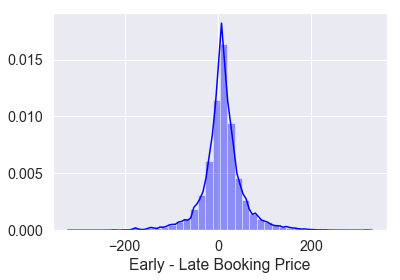

In [6]:

sns.set(font_scale=1.3)
ax = sns.distplot(df['price_diff'],bins=40,color = 'blue')
ax.set_xlabel("Early - Late Booking Price")

In [ ]:
##listings_12_18_df = pd.read_csv('./listings_12_18.csv')
##listings_12_18_df[listings_12_18_df.id == 22630322].head(